### Solve IK for `myohuman` 

In [45]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,r2quat,get_uv_dict_myohuman,get_p_target_myohuman, rpy2R
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.6]


### Parse `myohuman_v0.1`

In [46]:
xml_path = '../asset/myohuman_v0.1(mj236).mjb'
env = MuJoCoParserClass(name='myosuite',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0020] HZ:[500]
n_dof (=nv):[83]
n_geom:[82]
geom_names:['floor', 'r_pelvis', 'l_pelvis', 'sacrum', 'r_femur', 'r_tibia', 'r_fibula', 'r_talus', 'r_foot', 'r_bofoot', 'r_patella', 'l_femur', 'l_tibia', 'l_fibula', 'l_talus', 'l_foot', 'l_bofoot', 'l_patella', 'hat_spine', 'hat_jaw', 'hat_skull', 'hat_ribs_scap', 'humerus_r', 'ulna', 'radius', 'lunate', 'scaphoid', 'pisiform', 'triquetrum', 'capitate', 'trapezium', '1mc', 'thumbprox', 'thumbdist', 'trapezoid', 'hamate', '2mc', '2proxph', '2midph', '2distph', '3mc', '3proxph', '3midph', '3distph', '4mc', '4proxph', '4midph', '4distph', '5mc', '5proxph', '5midph', '5distph', 'humerus_lv', 'ulna_l', 'radius_l', 'lunate_l', 'scaphoid_l_geom_1', 'pisiform_l_geom_1', 'triquetrum_l_geom_1', 'capitate_l_geom_1', 'trapezium_l_geom_1', 'firstmc_l_geom_1', 'proximal_thumb_l_geom_1', 'distal_thumb_l_geom_1', 'trapezoid_l_geom_1', 'hamate_l_geom_1', 'secondmc_l_geom_1', '2proxph_l_geom_1', '2midph_l_geom_1', '2distph_l_geom_1', 'thirdmc_l_geom_

# Target BVH

In [4]:
# code edited from https://github.com/tekulvw/bvh-converter

from bvh.skeleton import process_bvhfile, process_bvhkeyframe

mocap = process_bvhfile("../asset/bvh/M02F4V1.bvh", DEBUG=False)
index = [0,9,10,11,12,44,45,46,47,          # Hips, Spine, LeftShoulder ~ LeftHand
        67,68,69,70,71,62,63,64,65,66,      # LeftPinky, LeftRing
        57,58,59,60,61,52,53,54,55,56,      # LeftMiddle, LeftIndex
        48,49,50,51,16,17,18,19,            # LeftThumb, RightShoulder ~ RightHand
        39,40,41,42,43,34,35,36,37,38,      # RightPinky, RightRing
        29,30,31,32,33,24,25,26,27,28,      # RightMiddle, RightIndex
        20,21,22,23,13,14,15,               # RightThumb, Neck, Head
        5,6,7,8,1,2,3,4]                    # LeftUpLeg ~ LeftFoot, RightUpLeg ~ RightFoot

print("Analyzing frames...")
for i in range(mocap.frames):
    new_frame = process_bvhkeyframe(mocap.keyframes[i], mocap.root, mocap.dt * i)
print("done")

pos_header, pos = mocap.get_frames_worldpos()
rot_header, rot = mocap.get_frames_rotations()

num_frames = mocap.frames
num_joints = 72

p_full = np.zeros((num_frames, num_joints, 3))
r_full = np.zeros((num_frames, num_joints, 3))
timesteps = np.zeros(num_frames)

for i in range(num_frames):
    timesteps[i] = i * mocap.dt
    for (j,k) in enumerate(index):
        p_full[i,k,:] = np.array(pos[i][3*j+1:3*j+4]) / 100 # cm to mm
        r_full[i,k,:] = np.array(rot[i][3*j+1:3*j+4])

p_full = p_full[:,:,[2,0,1]]
r_full = r_full[:,:,[2,0,1]]

frame_number = 0
p = p_full[frame_number]
r = r_full[frame_number]

uv_dict = get_uv_dict_myohuman(p)
p_target = get_p_target_myohuman(p, uv_dict)

Reading BVH file...
done
Building skeleton...
done
Analyzing frames...
done


In [44]:
print(uv_dict)

inner = env.model.body(3).pos @ uv_dict['pelvis2femur_r']
norm = np.linalg.norm(env.model.body(3).pos) * np.linalg.norm(uv_dict['pelvis2femur_r'])
pitch = np.arccos(inner / norm)

# R = rpy2r([0, pitch, 0])
# new_vector = uv_dict['pelvis2femur_r']@R

# np.cos(new_vector, env.model.body(3).pos)
pitch

{'pelvis2femur_r': array([-0.09, -0.98, -0.17]), 'femur_r2tibia_r': array([-0.04, -0.08, -1.  ]), 'tibia_r2talus_r': array([-0.08, -0.08, -0.99]), 'pelvis2femur_l': array([ 0.1 ,  0.98, -0.16]), 'femur_l2tibia_l': array([-0.1 ,  0.11, -0.99]), 'tibia_l2talus_l': array([-0.06,  0.12, -0.99]), 'pelvis2torso': array([-0.05, -0.  ,  1.  ]), 'torso2humerus_r': array([-0.01, -0.45,  0.89]), 'humerus_r2radius': array([-0.09, -0.2 , -0.98]), 'radius2lunate': array([ 0.12, -0.11, -0.99]), 'torso2humerus_l': array([0.15, 0.35, 0.93]), 'humerus_l2radius_l': array([ 0.  ,  0.2 , -0.98]), 'radius_l2lunate_l': array([ 0.14,  0.13, -0.98])}


0.984581445349909

### Set IK targets (`24` in total: `10` for body & `14` for hands)

In [4]:
# Set which joints to control
ctrl_joint_names = env.joint_names # <==
joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

env.body_names
# ik_body_names = ['right_pelvis','right_knee','right_ankle','left_pelvis','left_knee','left_ankle','spine','neck',
#                  'right_shoulder','right_elbow','right_wrist','left_shoulder','left_elbow','left_wrist',
#                  'rh_meta_1','rh_prox_1','rh_dist_1','rh_tip_1',
#                  'rh_meta_2','rh_prox_2','rh_med_2','rh_dist_2','rh_tip_2',
#                  'rh_meta_3','rh_prox_3','rh_med_3','rh_dist_3','rh_tip_3',
#                  'rh_meta_4','rh_prox_4','rh_med_4','rh_dist_4','rh_tip_4',
#                  'rh_meta_5','rh_prox_5','rh_med_5','rh_dist_5','rh_tip_5',
#                  'lh_meta_1','lh_prox_1','lh_dist_1','lh_tip_1',
#                  'lh_meta_2','lh_prox_2','lh_med_2','lh_dist_2','lh_tip_2',
#                  'lh_meta_3','lh_prox_3','lh_med_3','lh_dist_3','lh_tip_3',
#                  'lh_meta_4','lh_prox_4','lh_med_4','lh_dist_4','lh_tip_4',
#                  'lh_meta_5','lh_prox_5','lh_med_5','lh_dist_5','lh_tip_5']
ik_body_names = ['femur_r','tibia_r','talus_r','femur_l','tibia_l','talus_l','torso',
                 'humerus_r','radius','lunate','humerus_l','radius_l','lunate_l']

ik_target_indices = [1,2,3,5,6,7,9,
                     17,18,19,45,46,47]

IK_Ps = [True]*len(ik_body_names)
IK_Rs = [False]*len(ik_body_names)

ik_p_trgts = []
ik_R_trgts = []

for body in ik_body_names:
    ik_p_trgts.append(p_target[body])

for i in ik_target_indices:
    ik_R_trgts.append(rpy2R(np.radians(r[i]),[1,2,0]))

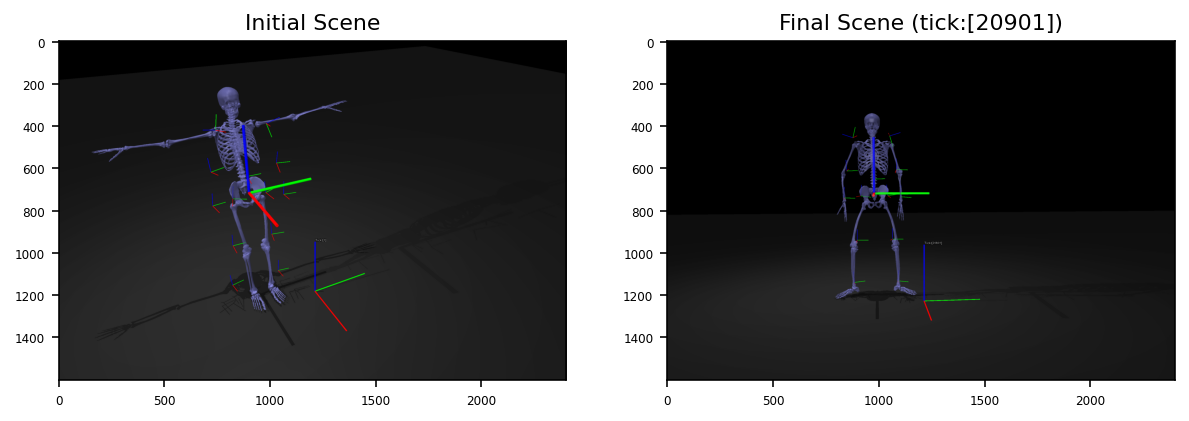

In [5]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Myohuman EmotionMocap',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])

# Reset and loop 
env.reset()

# # Good starting position
# init_joint_names = ['rs1','rs2','rs3','ls1','ls2','ls3','re','le']
# q_init = np.radians([70,25,-5,-70,-25,-5,35,-35])
# joint_idxs_init = [env.model.joint(jname).qposadr[0] for jname in init_joint_names]
# env.forward(q=q_init,joint_idxs=joint_idxs_init)

PERTURB_BASE_POSITION = True
if PERTURB_BASE_POSITION:
    jntadr = env.model.body('body_root').jntadr[0]
    qposadr = env.model.jnt_qposadr[jntadr]
    p[0][2] -= 1.
    base_pos = p[0] # modify base position
    r[0] -= [-90, 0, 0]
    env.data.qpos[qposadr:qposadr+3] = base_pos
    env.data.qpos[qposadr+3:qposadr+6] = np.radians(r[0])

q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
q = q_ctrl_init.copy()

FIRST_FLAG = True
while env.is_viewer_alive():
    
    # Solve inverse kinematics
    J_list,ik_err_list = [],[]
    for ik_idx,ik_body_name in enumerate(ik_body_names):
        ik_p_trgt = ik_p_trgts[ik_idx]
        ik_R_trgt = ik_R_trgts[ik_idx]
        IK_P = IK_Ps[ik_idx]
        IK_R = IK_Rs[ik_idx]
        J,ik_err = env.get_ik_ingredients(
            body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
            IK_P=IK_P,IK_R=IK_R)
        J[:,:6]=0
        J_list.append(J)
        ik_err_list.append(ik_err)
    J_stack      = np.vstack(J_list)
    ik_err_stack = np.hstack(ik_err_list)
    dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
    q = q + dq[joint_idxs_jac]
    
    # FK
    env.data.qpos[joint_idxs_fwd] = q
    q_couple = env.data.qpos.copy()

    env.forward(q=q_couple,INCREASE_TICK=True)
    
    if env.loop_every(tick_every=10):
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        
        # Text information
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3),PLOT_AXIS=False,
                   label='Tick:[%d]'%(env.tick))
        
        # Plot bodies
        env.plot_T(p=base_pos+[0, 0, 1.],R=np.eye(3,3),PLOT_AXIS=True,axis_len=0.5,axis_width=0.01)
        # env.plot_body_T(body_name='body_root',PLOT_AXIS=True,axis_len=0.5,axis_width=0.01)
        for body_name in env.body_names:
            p,R = env.get_pR_body(body_name=body_name)
            env.plot_T(p=p,R=R,PLOT_AXIS=False,axis_len=0.05,axis_width=0.005)
            
        # Plot IK target
        for ik_idx,ik_body_name in enumerate(ik_body_names):
            ik_p_trgt = ik_p_trgts[ik_idx]
            ik_R_trgt = ik_R_trgts[ik_idx]
            # env.plot_body_T(body_name=ik_body_name,
                            # PLOT_AXIS=True,axis_len=0.2,axis_width=0.01)
            env.plot_T(p=ik_p_trgt,R=ik_R_trgt,
                       PLOT_AXIS=True,axis_len=0.1,axis_width=0.002)
        
        # Plot revolute joints with arrow
        # for rev_joint_idx,rev_joint_name in zip(env.rev_joint_idxs,env.rev_joint_names):
        #     axis_joint = env.model.jnt_axis[rev_joint_idx]
        #     p_joint,R_joint = env.get_pR_joint(joint_name=rev_joint_name)
        #     axis_world = R_joint@axis_joint
        #     axis_rgba = np.append(np.eye(3)[:,np.argmax(axis_joint)],0.2)
        #     axis_len,axis_r = 0.1,0.01
        #     env.plot_arrow_fr2to(
        #         p_fr=p_joint,p_to=p_joint+axis_len*axis_world,
        #         r=axis_r,rgba=axis_rgba)
            
        # Plot contact information
        # env.plot_contact_info(h_arrow=0.01,rgba_arrow=[1,0,0,0.01],r_sphere=0.005,
        #                       PRINT_CONTACT_BODY=True)
        env.render()

    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
    if env.is_viewer_alive() and env.loop_every(tick_every=100):
        scene_img_final = env.grab_image()
    FIRST_FLAG = False
        
# Close MuJoCo viewer
env.close_viewer()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()

# Entire Sequence

In [11]:
import numpy as np
import pickle
from bvh.skeleton import process_bvhfile, process_bvhkeyframe

mocap = process_bvhfile("../asset/bvh/M02F4V1.bvh", DEBUG=False)
index = [0,9,10,11,12,44,45,46,47,         # Hips, Spine, LeftShoulder ~ LeftHand
        67,68,69,70,71,62,63,64,65,66,      # LeftPinky, LeftRing
        57,58,59,60,61,52,53,54,55,56,      # LeftMiddle, LeftIndex
        48,49,50,51,16,17,18,19,            # LeftThumb, RightShoulder ~ RightHand
        39,40,41,42,43,34,35,36,37,38,      # RightPinky, RightRing
        29,30,31,32,33,24,25,26,27,28,      # RightMiddle, RightIndex
        20,21,22,23,13,14,15,               # RightThumb, Neck, Head
        5,6,7,8,1,2,3,4]                    # LeftUpLeg ~ LeftFoot, RightUpLeg ~ RightFoot

print("Analyzing frames...")
for i in range(mocap.frames):
    new_frame = process_bvhkeyframe(mocap.keyframes[i], mocap.root, mocap.dt * i)
print("done")

pos_header, pos = mocap.get_frames_worldpos()
rot_header, rot = mocap.get_frames_rotations()

num_frames = mocap.frames
num_joints = 72

p_full = np.zeros((num_frames, num_joints, 3))
r_full = np.zeros((num_frames, num_joints, 3))
timesteps = np.zeros(num_frames)

for i in range(num_frames):
    timesteps[i] = i * mocap.dt
    for (j,k) in enumerate(index):
        p_full[i,k,:] = np.array(pos[i][3*j+1:3*j+4]) / 100
        r_full[i,k,:] = np.array(rot[i][3*j+1:3*j+4])

p_full = p_full[:,:,[2,0,1]]
r_full = r_full[:,:,[2,0,1]]

qpos_data = np.zeros((num_frames, env.data.qpos.shape[0]))

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Myohuman EmotionMocap',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])

for timestep in range(num_frames):
    p = p_full[timestep]
    r = r_full[timestep]
    uv_dict = get_uv_dict_myohuman(p)
    p_target = get_p_target_myohuman(p, uv_dict)

    env.reset()

    # Set which joints to control
    ctrl_joint_names = env.joint_names # <==
    joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
    joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
    q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
    n_ctrl_joint = len(ctrl_joint_names)

    ik_body_names = ['femur_r','tibia_r','talus_r','femur_l','tibia_l','talus_l','torso',
                     'humerus_r','radius','lunate','humerus_l','radius_l','lunate_l']

    ik_target_indices = [1,2,3,5,6,7,9,
                        17,18,19,45,46,47]

    IK_Ps = [True]*len(ik_body_names)
    IK_Rs = [False]*len(ik_body_names)
    ik_p_trgts = []
    ik_R_trgts = []

    for body in ik_body_names:
        ik_p_trgts.append(p_target[body])

    for i in ik_target_indices:
        ik_R_trgts.append(rpy2R(np.radians(r[i]),[1,2,0]))


    PERTURB_BASE_POSITION = True
    if PERTURB_BASE_POSITION:
        jntadr = env.model.body('body_root').jntadr[0]
        qposadr = env.model.jnt_qposadr[jntadr]
        p[0][2] -= 1.
        base_pos = p[0] # modify base position
        r[0] -= [-90, 0, 0]
        env.data.qpos[qposadr:qposadr+3] = base_pos
        env.data.qpos[qposadr+3:qposadr+6] = np.radians(r[0])

    # Reset and loop 
    q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
    q = q_ctrl_init.copy()

    FIRST_FLAG = True
    while env.tick < 500:
        
        # Solve inverse kinematics
        J_list,ik_err_list = [],[]
        for ik_idx,ik_body_name in enumerate(ik_body_names):
            ik_p_trgt = ik_p_trgts[ik_idx]
            ik_R_trgt = ik_R_trgts[ik_idx]
            IK_P = IK_Ps[ik_idx]
            IK_R = IK_Rs[ik_idx]
            J,ik_err = env.get_ik_ingredients(
                body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                IK_P=IK_P,IK_R=IK_R)
            # J[:,:6] = 0
            J_list.append(J)
            ik_err_list.append(ik_err)
        J_stack      = np.vstack(J_list)
        ik_err_stack = np.hstack(ik_err_list)
        dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
        q = q + dq[joint_idxs_jac]
        
        # FK
        env.data.qpos[joint_idxs_fwd] = q
        q_couple = env.data.qpos.copy()

        # Plot IK target
        for ik_idx,ik_body_name in enumerate(ik_body_names):
            ik_p_trgt = ik_p_trgts[ik_idx]
            ik_R_trgt = ik_R_trgts[ik_idx]
            # env.plot_body_T(body_name=ik_body_name,
                            # PLOT_AXIS=True,axis_len=0.2,axis_width=0.01)
            env.plot_T(p=ik_p_trgt,R=ik_R_trgt,
                       PLOT_AXIS=True,axis_len=0.1,axis_width=0.002)


        env.forward(q=q_couple,INCREASE_TICK=True)
        # env.render()

    qpos_data[timestep,:] = np.array(q_couple)
    print("Timestep: ", timestep)

# Close MuJoCo viewer
env.close_viewer()

p_root = p_full[:,0,:]

pkl_data = {
    'length': num_frames,
    'root': p_root,
    'qpos': qpos_data
}
with open('../data/M02F4V1.pkl', 'wb') as f:
    pickle.dump(pkl_data, f)


Reading BVH file...
done
Building skeleton...
done
Analyzing frames...
done
Timestep:  0
Timestep:  1
Timestep:  2
Timestep:  3
Timestep:  4
Timestep:  5
Timestep:  6
Timestep:  7
Timestep:  8
Timestep:  9
Timestep:  10
Timestep:  11
Timestep:  12
Timestep:  13
Timestep:  14
Timestep:  15
Timestep:  16
Timestep:  17
Timestep:  18
Timestep:  19
Timestep:  20
Timestep:  21
Timestep:  22
Timestep:  23
Timestep:  24
Timestep:  25
Timestep:  26
Timestep:  27
Timestep:  28
Timestep:  29
Timestep:  30
Timestep:  31
Timestep:  32
Timestep:  33
Timestep:  34
Timestep:  35
Timestep:  36
Timestep:  37
Timestep:  38
Timestep:  39
Timestep:  40
Timestep:  41
Timestep:  42
Timestep:  43
Timestep:  44
Timestep:  45
Timestep:  46
Timestep:  47
Timestep:  48
Timestep:  49
Timestep:  50
Timestep:  51
Timestep:  52
Timestep:  53
Timestep:  54
Timestep:  55
Timestep:  56
Timestep:  57
Timestep:  58
Timestep:  59
Timestep:  60
Timestep:  61
Timestep:  62
Timestep:  63
Timestep:  64
Timestep:  65
Timestep: 

In [ ]:
env.open_interactive_viewer()